<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/machinehack/subscriber_prediction_hackathon/notebooks/00_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

**Utils**

In [178]:
import gc
import os
import time
import warnings

gc.enable()
warnings.filterwarnings(action='ignore')

**Data analysis**

In [179]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

**Visualization**

In [180]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**Modeling**

In [181]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

**Reproducibility**

In [182]:
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

**Data**

In [183]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/machinehack/subscriber_prediction_hackathon/data'

train = pd.read_csv(f'{DATA_URL}/raw/train.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test.csv')
sample_sub = pd.read_csv(f'{DATA_URL}/raw/submission.csv')

# Data Overview

In [184]:
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y_bool
0,51,admin.,married,tertiary,no,148,no,no,cellular,15,apr,263,2,-1,0,unknown,0
1,55,blue-collar,married,secondary,no,7160,yes,no,unknown,4,may,315,1,-1,0,unknown,0
2,65,blue-collar,divorced,tertiary,no,2197,yes,no,cellular,12,may,102,2,-1,0,unknown,0
3,25,admin.,married,secondary,no,6658,yes,no,cellular,16,feb,197,1,-1,0,unknown,1
4,36,services,married,secondary,no,1761,yes,no,cellular,19,sep,177,1,-1,0,success,0


In [185]:
sample_sub.head()

,y_bool
0,0
1,0
2,0
3,0
4,0


**Datatypes and dimensions**

In [186]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        21000 non-null  int64 
 1   job        21000 non-null  object
 2   marital    21000 non-null  object
 3   education  21000 non-null  object
 4   default    21000 non-null  object
 5   balance    21000 non-null  int64 
 6   housing    21000 non-null  object
 7   loan       21000 non-null  object
 8   contact    21000 non-null  object
 9   day        21000 non-null  int64 
 10  month      21000 non-null  object
 11  duration   21000 non-null  int64 
 12  campaign   21000 non-null  int64 
 13  pdays      21000 non-null  int64 
 14  previous   21000 non-null  int64 
 15  poutcome   21000 non-null  object
 16  y_bool     21000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 2.7+ MB


In [187]:
train.shape, test.shape, sample_sub.shape

((21000, 17), (9000, 16), (9000, 1))

**Missing values**

In [188]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

No missing values.

**TARGET**

In [189]:
TARGET = 'y_bool'

In [190]:
train[TARGET].value_counts()

0    15349
1     5651
Name: y_bool, dtype: int64

In [191]:
train[TARGET].value_counts(normalize=True)

0    0.7309
1    0.2691
Name: y_bool, dtype: float64

Moderately imbalanced.

# Feature exploration (and preprocessing)

In [192]:
original_features = list(test.columns)

In [193]:
category_mappings = {}

### Utility functions

In [194]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 3))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    ax[0].minorticks_on()
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    ax[1].minorticks_on()
    fig.tight_layout()
    plt.show()

In [195]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for distribution of continuous feature
    split by categories of Target variable.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    ax.minorticks_on()
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax, cut=0)
    fig.tight_layout()
    plt.show()

In [196]:
def explore_cont(feature):
    #Feature distribution 
    describe_df = pd.DataFrame()
    describe_df.index = train[feature].describe().index
    describe_df['Train'] = train[feature].describe().values
    describe_df['Test'] = test[feature].describe().values
    print('\nFeature distribution:')
    display(describe_df.T)
    plot_cont(feature)
    #Feature distribution grouped by target class
    print(f'\nFeature distribution vs target variable:')
    display(train.groupby(TARGET)[feature].describe())
    plot_cont_vs_target(feature)

In [197]:
def explore_cat(feature):
    #Unique values
    print(f'\nNumber of unique values: ' \
          f'Train - {train[feature].nunique()}, Test - {test[feature].nunique()}')
    print(f'Unique values: ')
    print(f'Train - {pd.unique(train[feature])}')
    print(f'Test - {pd.unique(test[feature])}')
    #Value counts
    print(f'\nNormalized value counts:')
    train_value_counts = train[feature].value_counts(normalize=True, dropna=False).to_frame()
    test_value_counts = test[feature].value_counts(normalize=True, dropna=False).to_frame()
    counts_df = train_value_counts.join(test_value_counts, lsuffix='_Train', rsuffix='_Test')
    display(counts_df.T)
    #Target grouped by feature
    print(f'\nTarget value counts grouped by feature:')
    display(train.groupby(feature)[TARGET].value_counts(normalize=True))

### age


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,36.998,10.4847,19.0,29.0,35.0,45.0,87.0
Test,9000.0,36.934,10.4938,19.0,28.0,35.0,45.0,87.0


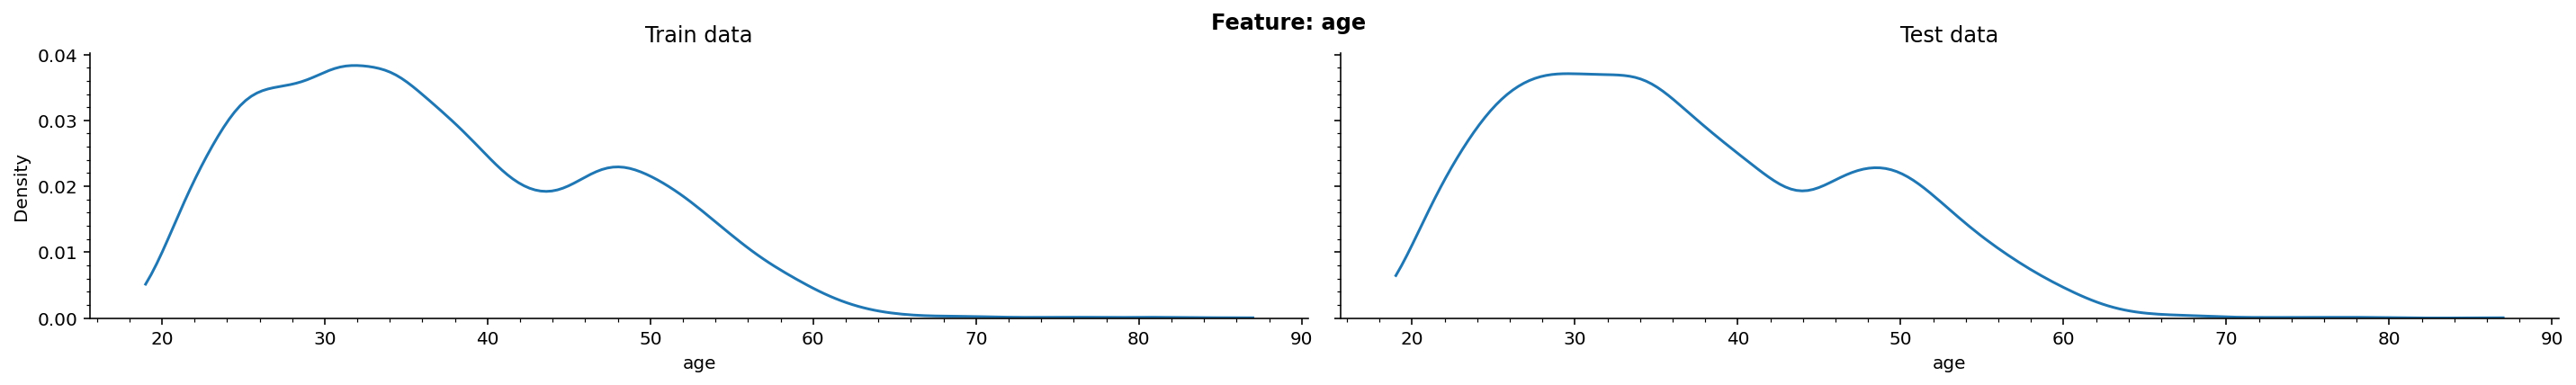


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,37.3145,10.5411,19.0,29.0,36.0,46.0,87.0
1,5651.0,36.1382,10.2820,19.0,28.0,34.0,44.0,84.0


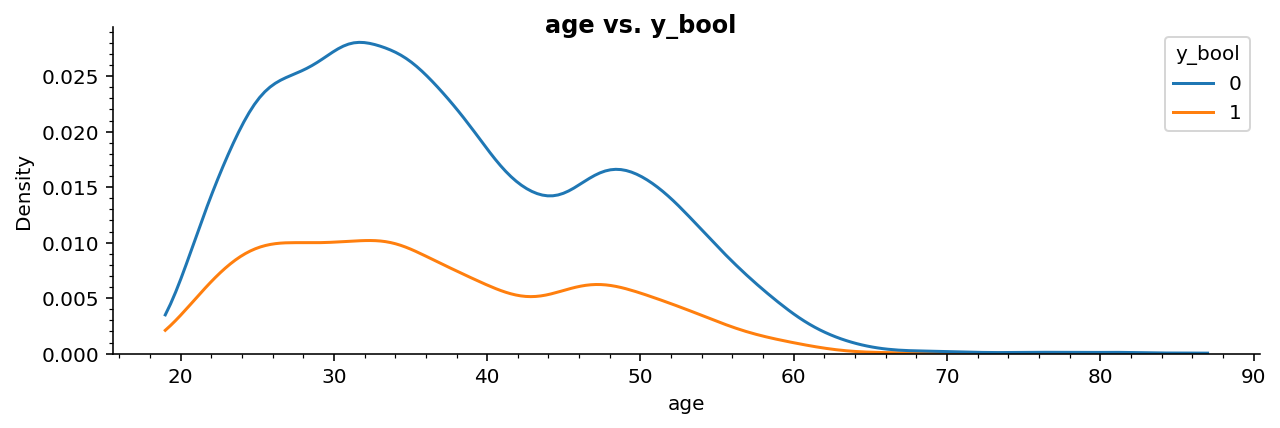

In [198]:
explore_cont('age')

In [199]:
train['age_bins'], bins = pd.qcut(x=train['age'], q=4, labels=False, retbins=True)
test['age_bins'] = pd.cut(x=test['age'], bins=bins, labels=False, include_lowest=True)

In [200]:
bins

array([19., 29., 35., 45., 87.])

In [201]:
explore_cat('age_bins')


Number of unique values: Train - 4, Test - 4
Unique values: 
Train - [3 0 2 1]
Test - [2 0 3 1]

Normalized value counts:


,0,3,2,1
age_bins_Train,0.2813,0.2451,0.2437,0.2299
age_bins_Test,0.2894,0.2467,0.2407,0.2232



Target value counts grouped by feature:


age_bins  y_bool
0         0         0.6990
          1         0.3010
1         0         0.7328
          1         0.2672
2         0         0.7444
          1         0.2556
3         0         0.7523
          1         0.2477
Name: y_bool, dtype: float64

### job

In [202]:
explore_cat('job')


Number of unique values: Train - 12, Test - 12
Unique values: 
Train - ['admin.' 'blue-collar' 'services' 'self-employed' 'technician'
 'management' 'unknown' 'unemployed' 'retired' 'housemaid' 'entrepreneur'
 'student']
Test - ['technician' 'management' 'blue-collar' 'unemployed' 'retired' 'services'
 'admin.' 'self-employed' 'entrepreneur' 'student' 'unknown' 'housemaid']

Normalized value counts:


,blue-collar,technician,management,admin.,services,retired,self-employed,entrepreneur,unemployed,student,unknown,housemaid
job_Train,0.2356,0.2135,0.1833,0.1558,0.0829,0.0487,0.0253,0.0160,0.0117,0.0098,0.0095,0.0080
job_Test,0.2270,0.2180,0.1836,0.1568,0.0833,0.0511,0.0261,0.0171,0.0099,0.0094,0.0098,0.0079



Target value counts grouped by feature:


job            y_bool
admin.         0         0.7448
               1         0.2552
blue-collar    0         0.7225
               1         0.2775
entrepreneur   0         0.6896
               1         0.3104
housemaid      0         0.6726
               1         0.3274
management     0         0.7205
               1         0.2795
retired        0         0.7309
               1         0.2691
self-employed  0         0.7180
               1         0.2820
services       0         0.7414
               1         0.2586
student        0         0.7268
               1         0.2732
technician     0         0.7413
               1         0.2587
unemployed     0         0.7033
               1         0.2967
unknown        0         0.7789
               1         0.2211
Name: y_bool, dtype: float64

In [203]:
category_mappings['job'] = {
    'unknown': -1, 'unemployed': 0, 'student': 1, 'retired': 2,
    'housemaid': 3,  'entrepreneur': 4, 'self-employed': 5, 
    'technician': 6, 'blue-collar': 7, 'services': 8,
    'management': 9, 'admin.': 10
}

In [204]:
job_groups = {
    'unknown': -1,
    'housemaid': 0, 'entrepreneur': 0, 'unemployed': 0,
    'self-employed': 1, 'management': 1, 'blue-collar': 1,
    'student': 2, 'retired': 2,
    'admin.': 3, 'services': 3, 'technician': 3 
}

In [205]:
train['job_groups'] = train['job'].replace(job_groups)
test['job_groups'] = test['job'].replace(job_groups)

In [206]:
explore_cat('job_groups')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [ 3  1 -1  0  2]
Test - [ 3  1  0  2 -1]

Normalized value counts:


,3,1,2,0,-1
job_groups_Train,0.4522,0.4442,0.0584,0.0357,0.0095
job_groups_Test,0.4581,0.4367,0.0606,0.0349,0.0098



Target value counts grouped by feature:


job_groups  y_bool
-1          0         0.7789
            1         0.2211
 0          0         0.6903
            1         0.3097
 1          0         0.7214
            1         0.2786
 2          0         0.7302
            1         0.2698
 3          0         0.7425
            1         0.2575
Name: y_bool, dtype: float64

### marital

In [207]:
explore_cat('marital')


Number of unique values: Train - 3, Test - 3
Unique values: 
Train - ['married' 'divorced' 'single']
Test - ['divorced' 'married' 'single']

Normalized value counts:


,married,single,divorced
marital_Train,0.6387,0.1845,0.1768
marital_Test,0.6306,0.1921,0.1773



Target value counts grouped by feature:


marital   y_bool
divorced  0         0.7280
          1         0.2720
married   0         0.7289
          1         0.2711
single    0         0.7406
          1         0.2594
Name: y_bool, dtype: float64

In [208]:
category_mappings['marital'] = {'single': 0, 'married': 1, 'divorced': 2}

### education

In [209]:
explore_cat('education')


Number of unique values: Train - 4, Test - 4
Unique values: 
Train - ['tertiary' 'secondary' 'primary' 'unknown']
Test - ['secondary' 'primary' 'unknown' 'tertiary']

Normalized value counts:


,secondary,tertiary,primary,unknown
education_Train,0.5078,0.3329,0.1065,0.0529
education_Test,0.5046,0.3353,0.1040,0.0561



Target value counts grouped by feature:


education  y_bool
primary    0         0.7336
           1         0.2664
secondary  0         0.7311
           1         0.2689
tertiary   0         0.7290
           1         0.2710
unknown    0         0.7351
           1         0.2649
Name: y_bool, dtype: float64

In [210]:
category_mappings['education'] = {'unknown': -1, 'primary': 0, 'secondary': 1, 'tertiary': 2}

### default

In [211]:
explore_cat('default')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['no' 'yes']
Test - ['no' 'yes']

Normalized value counts:


,no,yes
default_Train,0.9521,0.0479
default_Test,0.9511,0.0489



Target value counts grouped by feature:


default  y_bool
no       0         0.7308
         1         0.2692
yes      0         0.7326
         1         0.2674
Name: y_bool, dtype: float64

In [212]:
bool_mapping = {'no': 0, 'yes': 1}
category_mappings['default'] = bool_mapping

### balance


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,1607.4978,2991.1871,-2072.0,299.0,633.0,1875.00,71188.0
Test,9000.0,1609.2181,2986.9488,-2477.0,310.0,637.0,1891.25,71188.0


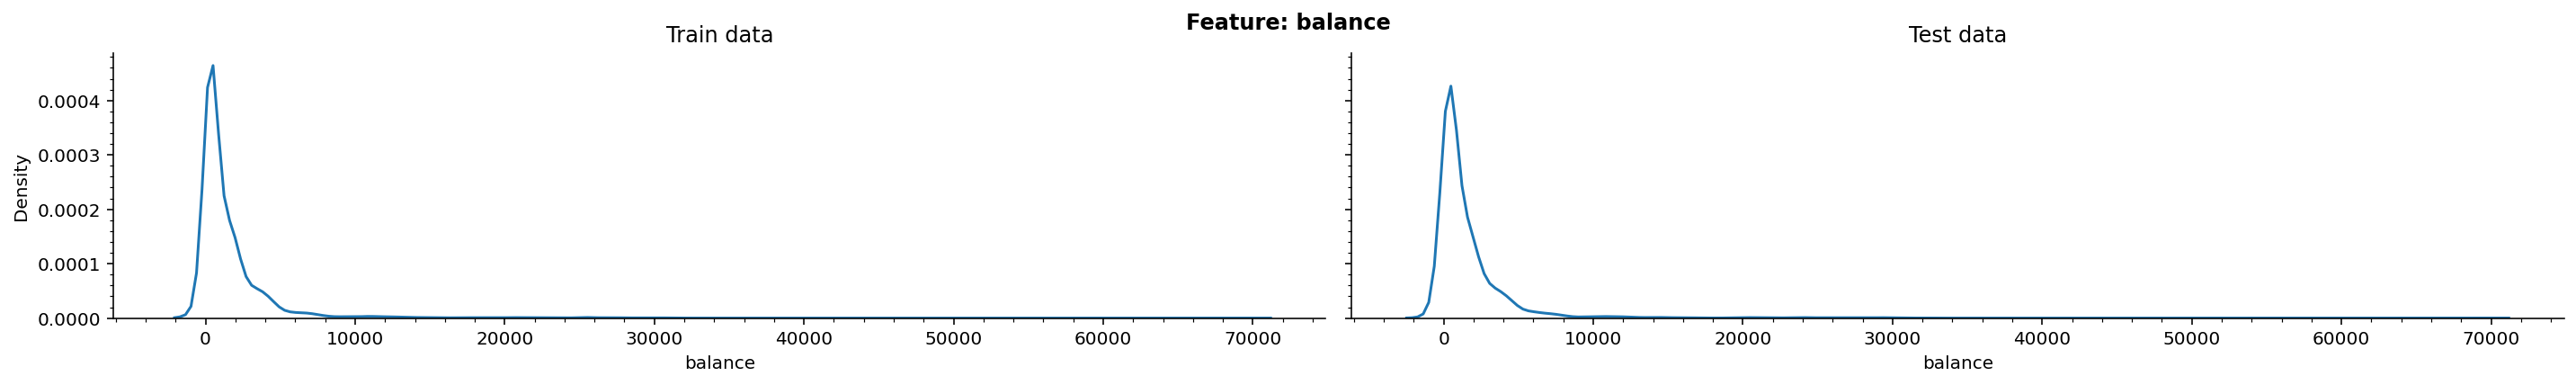


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,1626.9359,3021.0771,-2072.0,308.0,643.0,1882.0,71188.0
1,5651.0,1554.7009,2908.0585,-1602.0,275.5,604.0,1850.5,30961.0


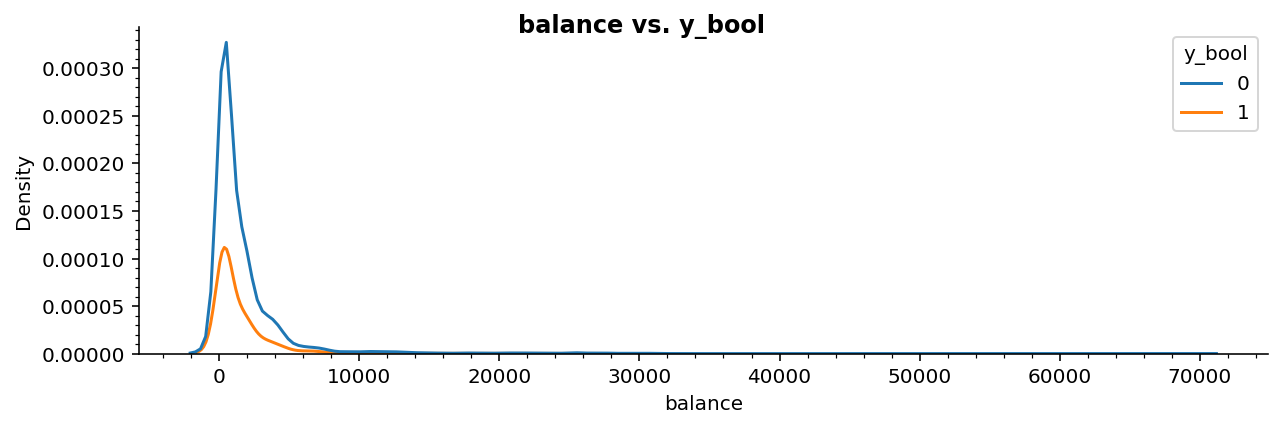

In [213]:
explore_cont('balance')

In [214]:
train['balance'].sort_values(ascending=False)[:5]

4788    71188
5112    32187
168     31423
5288    31140
6063    30961
Name: balance, dtype: int64

In [215]:
train['balance'].sort_values(ascending=True)[:5]

671     -2072
15335   -1877
16979   -1768
4544    -1647
17041   -1602
Name: balance, dtype: int64

In [216]:
test['balance'].sort_values(ascending=False)[:5]

7993    71188
6064    32187
1171    31860
4929    30421
5834    30069
Name: balance, dtype: int64

In [217]:
test['balance'].sort_values(ascending=True)[:5]

441    -2477
8448   -1721
1071   -1669
4597   -1631
5916   -1456
Name: balance, dtype: int64

In [218]:
bins = [-2500, 0, 500, 1000, 3500, 72000]
train['balance_bins'] = pd.cut(x=train['balance'], bins=bins, labels=False)
test['balance_bins'] = pd.cut(x=test['balance'], bins=bins, labels=False)

In [219]:
explore_cat('balance_bins')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [1 4 3 2 0]
Test - [3 1 4 0 2]

Normalized value counts:


,1,3,2,4,0
balance_bins_Train,0.3293,0.2998,0.1808,0.1118,0.0783
balance_bins_Test,0.3281,0.2993,0.1813,0.1150,0.0762



Target value counts grouped by feature:


balance_bins  y_bool
0             0         0.6813
              1         0.3187
1             0         0.7250
              1         0.2750
2             0         0.7511
              1         0.2489
3             0         0.7324
              1         0.2676
4             0         0.7466
              1         0.2534
Name: y_bool, dtype: float64

### housing

In [220]:
explore_cat('housing')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['no' 'yes']
Test - ['yes' 'no']

Normalized value counts:


,yes,no
housing_Train,0.5363,0.4637
housing_Test,0.5342,0.4658



Target value counts grouped by feature:


housing  y_bool
no       0         0.7247
         1         0.2753
yes      0         0.7363
         1         0.2637
Name: y_bool, dtype: float64

In [221]:
category_mappings['housing'] = bool_mapping

### loan

In [222]:
explore_cat('loan')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - ['no' 'yes']
Test - ['yes' 'no']

Normalized value counts:


,no,yes
loan_Train,0.7721,0.2279
loan_Test,0.7724,0.2276



Target value counts grouped by feature:


loan  y_bool
no    0         0.7282
      1         0.2718
yes   0         0.7402
      1         0.2598
Name: y_bool, dtype: float64

In [223]:
category_mappings['loan'] = bool_mapping

### contact

In [224]:
explore_cat('contact')


Number of unique values: Train - 3, Test - 3
Unique values: 
Train - ['cellular' 'unknown' 'telephone']
Test - ['cellular' 'unknown' 'telephone']

Normalized value counts:


,cellular,unknown,telephone
contact_Train,0.6272,0.3016,0.0711
contact_Test,0.6172,0.3091,0.0737



Target value counts grouped by feature:


contact    y_bool
cellular   0         0.7341
           1         0.2659
telephone  0         0.7122
           1         0.2878
unknown    0         0.7286
           1         0.2714
Name: y_bool, dtype: float64

In [225]:
category_mappings['contact'] = {'unknown': -1, 'cellular': 0, 'telephone': 1}

### day


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,11.0566,7.4504,1.0,5.0,10.0,16.0,31.0
Test,9000.0,11.0378,7.4162,1.0,4.0,10.0,16.0,31.0


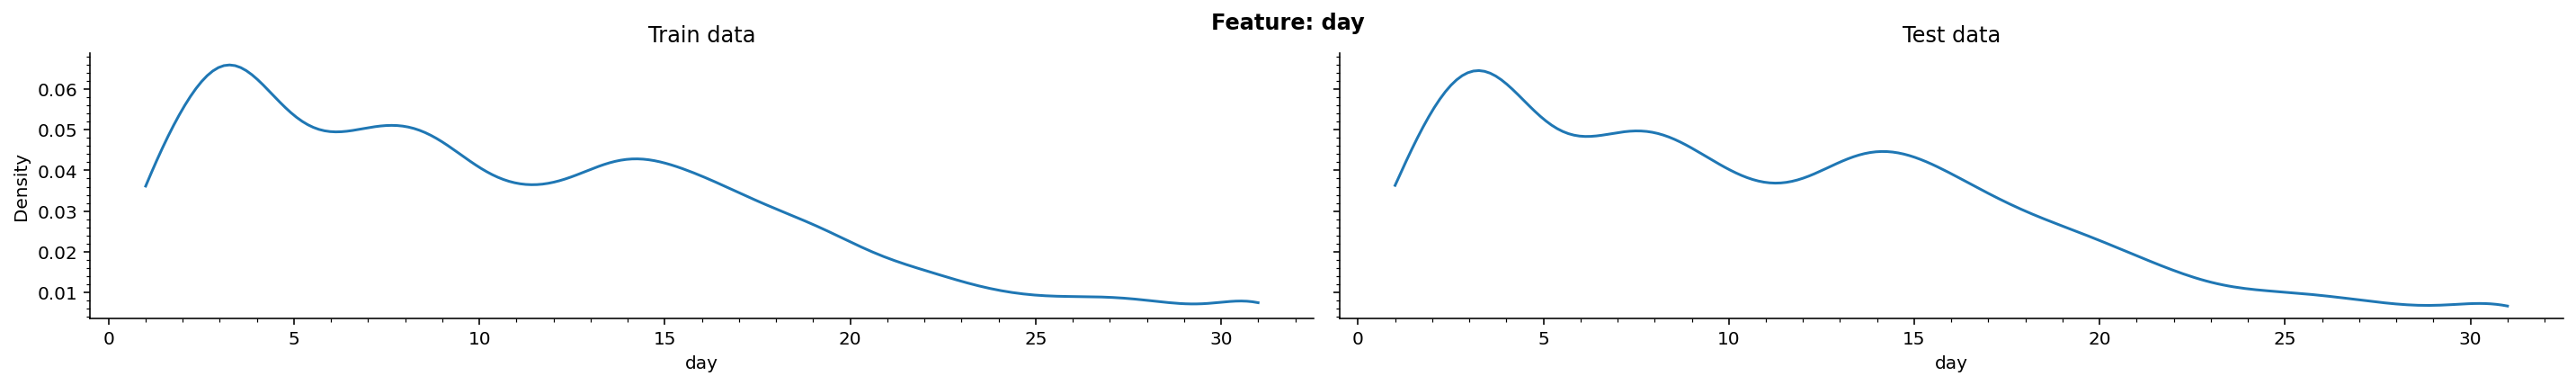


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,11.0958,7.4444,1.0,5.0,10.0,16.0,31.0
1,5651.0,10.9501,7.4663,1.0,4.0,9.0,16.0,31.0


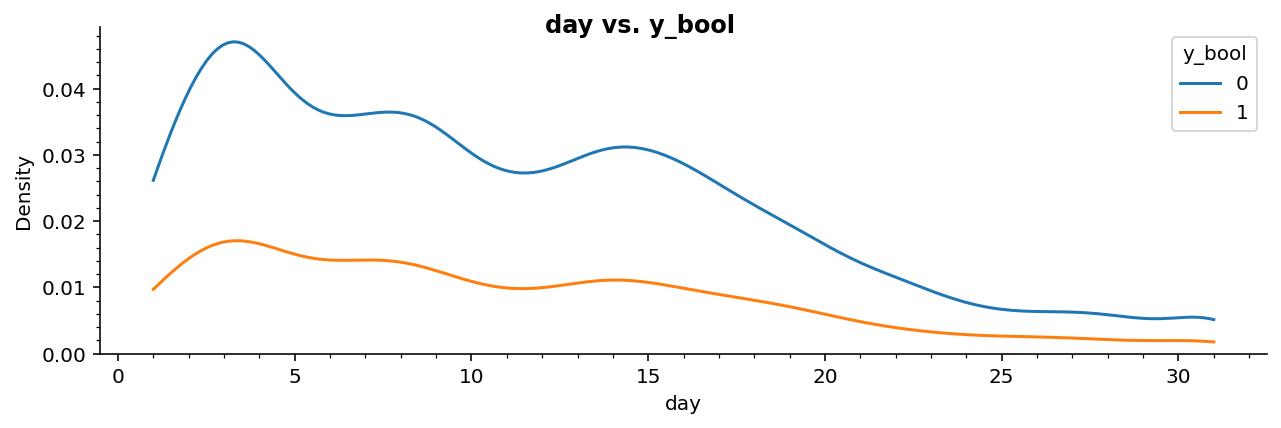

In [226]:
explore_cont('day')

In [227]:
train['day_bins'], bins = pd.qcut(x=train['day'], q=5, labels=False, retbins=True)
test['day_bins'] = pd.cut(x=test['day'], bins=bins, labels=False, include_lowest=True)
bins

array([ 1.,  4.,  8., 12., 17., 31.])

In [228]:
explore_cat('day_bins')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [3 0 2 4 1]
Test - [1 2 0 3 4]

Normalized value counts:


,0,3,1,4,2
day_bins_Train,0.2449,0.2026,0.1992,0.1959,0.1574
day_bins_Test,0.2519,0.2131,0.1927,0.1926,0.1498



Target value counts grouped by feature:


day_bins  y_bool
0         0         0.7245
          1         0.2755
1         0         0.7208
          1         0.2792
2         0         0.7422
          1         0.2578
3         0         0.7375
          1         0.2625
4         0         0.7333
          1         0.2667
Name: y_bool, dtype: float64

### month

In [229]:
explore_cat('month')


Number of unique values: Train - 12, Test - 12
Unique values: 
Train - ['apr' 'may' 'feb' 'sep' 'jun' 'nov' 'jul' 'mar' 'oct' 'aug' 'jan' 'dec']
Test - ['aug' 'nov' 'may' 'jul' 'apr' 'jun' 'dec' 'oct' 'feb' 'jan' 'sep' 'mar']

Normalized value counts:


,jul,may,jun,nov,aug,apr,feb,jan,oct,sep,mar,dec
month_Train,0.2386,0.1906,0.1340,0.1174,0.1041,0.0987,0.0520,0.0261,0.0134,0.0102,0.0086,0.0062
month_Test,0.2428,0.1917,0.1259,0.1204,0.1043,0.0967,0.0552,0.0241,0.0143,0.0103,0.0078,0.0064



Target value counts grouped by feature:


month  y_bool
apr    0         0.7246
       1         0.2754
aug    0         0.7493
       1         0.2507
dec    0         0.7328
       1         0.2672
feb    0         0.7557
       1         0.2443
jan    0         0.7505
       1         0.2495
jul    0         0.7302
       1         0.2698
jun    0         0.7099
       1         0.2901
mar    0         0.7293
       1         0.2707
may    0         0.7391
       1         0.2609
nov    0         0.7153
       1         0.2847
oct    0         0.7402
       1         0.2598
sep    0         0.7336
       1         0.2664
Name: y_bool, dtype: float64

In [230]:
month_bins = {
    'jan': 1, 'feb': 1,
    'mar': 2, 'apr': 2,
    'may': 3,
    'jun': 4,
    'jul': 5,
    'aug': 6, 'sep': 6, 'oct': 6,
    'nov': 7, 'dec': 7
}

train['month_bins'] = train['month'].replace(month_bins).astype('int')
test['month_bins'] = test['month'].replace(month_bins).astype('int')

In [231]:
explore_cat('month_bins')


Number of unique values: Train - 7, Test - 7
Unique values: 
Train - [2 3 1 6 4 7 5]
Test - [6 7 3 5 2 4 1]

Normalized value counts:


,5,3,4,6,7,2,1
month_bins_Train,0.2386,0.1906,0.1340,0.1277,0.1237,0.1073,0.0782
month_bins_Test,0.2428,0.1917,0.1259,0.1290,0.1269,0.1044,0.0793



Target value counts grouped by feature:


month_bins  y_bool
1           0         0.7540
            1         0.2460
2           0         0.7249
            1         0.2751
3           0         0.7391
            1         0.2609
4           0         0.7099
            1         0.2901
5           0         0.7302
            1         0.2698
6           0         0.7471
            1         0.2529
7           0         0.7162
            1         0.2838
Name: y_bool, dtype: float64

In [232]:
category_mappings['month'] = dict(zip(
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
    range(1, 13)
))

### duration


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,264.0850,288.1638,4.0,94.0,184.0,319.0,2703.0
Test,9000.0,259.7643,280.4747,4.0,93.0,183.0,316.0,2509.0


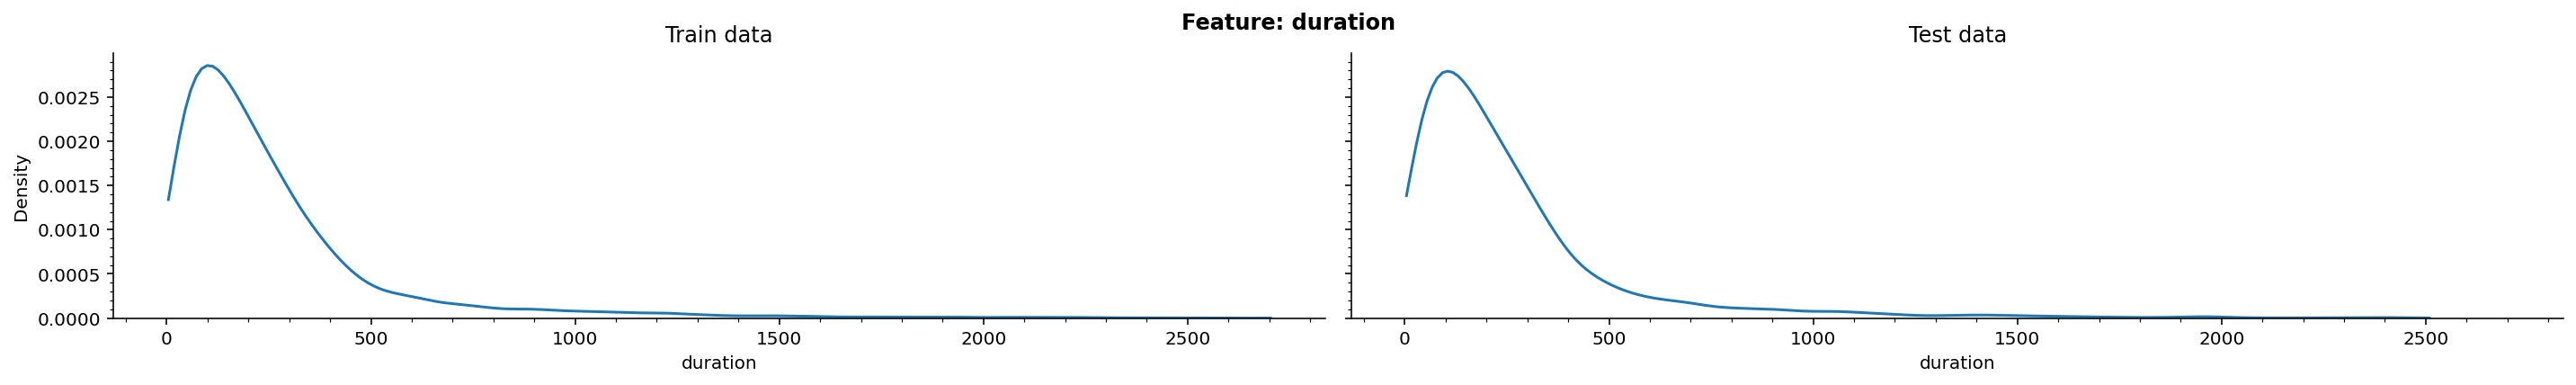


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,266.1807,290.0253,4.0,94.0,185.0,321.0,2703.0
1,5651.0,258.3930,282.9931,4.0,94.0,181.0,313.5,2552.0


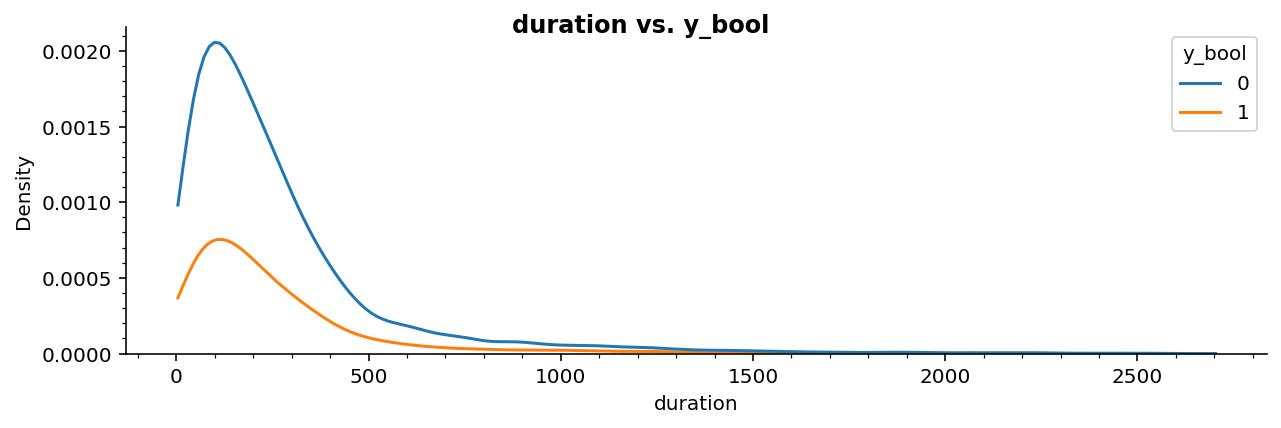

In [233]:
explore_cont('duration')

In [234]:
train['duration_bins'], bins = pd.qcut(x=train['duration'], q=4, labels=False, retbins=True)
test['duration_bins'] = pd.cut(x=test['duration'], bins=bins, labels=False, include_lowest=True)
bins

array([   4.,   94.,  184.,  319., 2703.])

In [235]:
explore_cat('duration_bins')


Number of unique values: Train - 4, Test - 4
Unique values: 
Train - [2 1 0 3]
Test - [1 0 3 2]

Normalized value counts:


,0,1,3,2
duration_bins_Train,0.2518,0.2503,0.2491,0.2488
duration_bins_Test,0.2553,0.2483,0.2442,0.2521



Target value counts grouped by feature:


duration_bins  y_bool
0              0         0.7307
               1         0.2693
1              0         0.7241
               1         0.2759
2              0         0.7286
               1         0.2714
3              0         0.7402
               1         0.2598
Name: y_bool, dtype: float64

### campaign


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,2.0134,1.5759,1.0,1.0,2.0,2.0,28.0
Test,9000.0,1.9802,1.4705,1.0,1.0,2.0,2.0,25.0


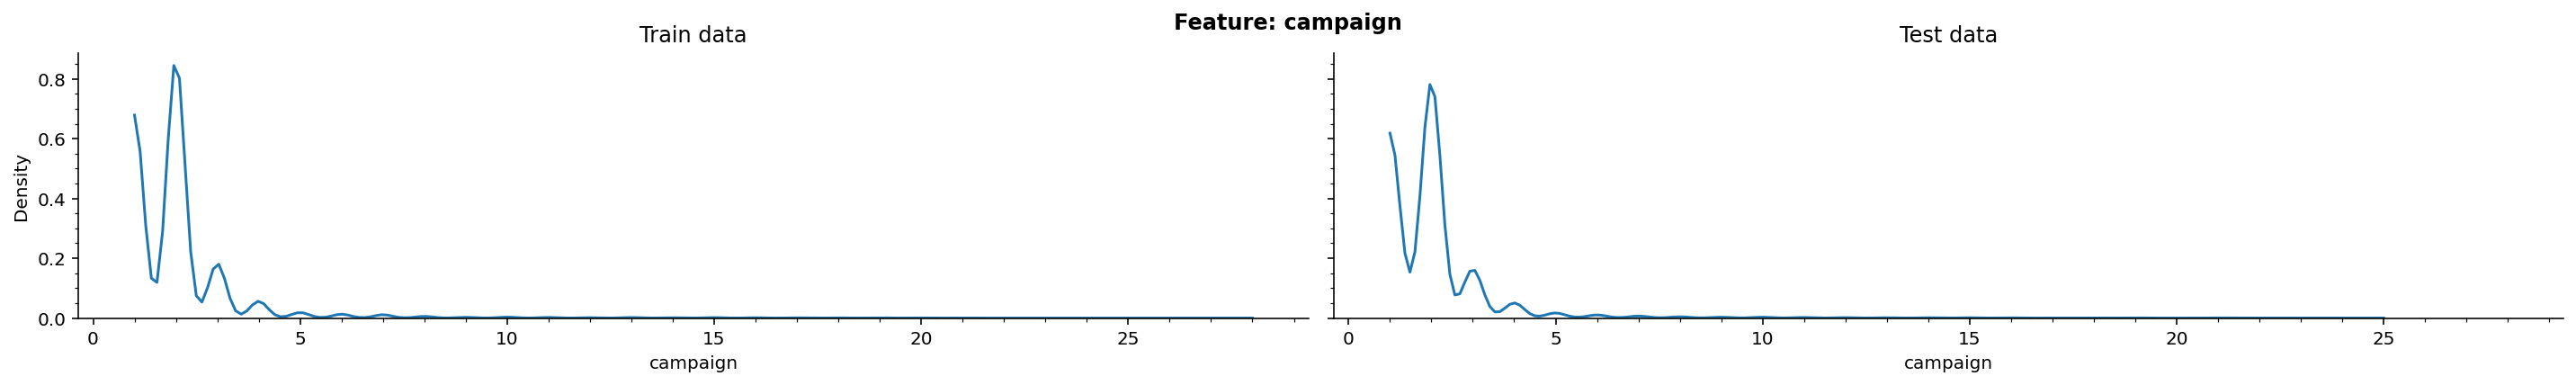


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,1.9967,1.5124,1.0,1.0,2.0,2.0,28.0
1,5651.0,2.0586,1.7360,1.0,1.0,2.0,2.0,27.0


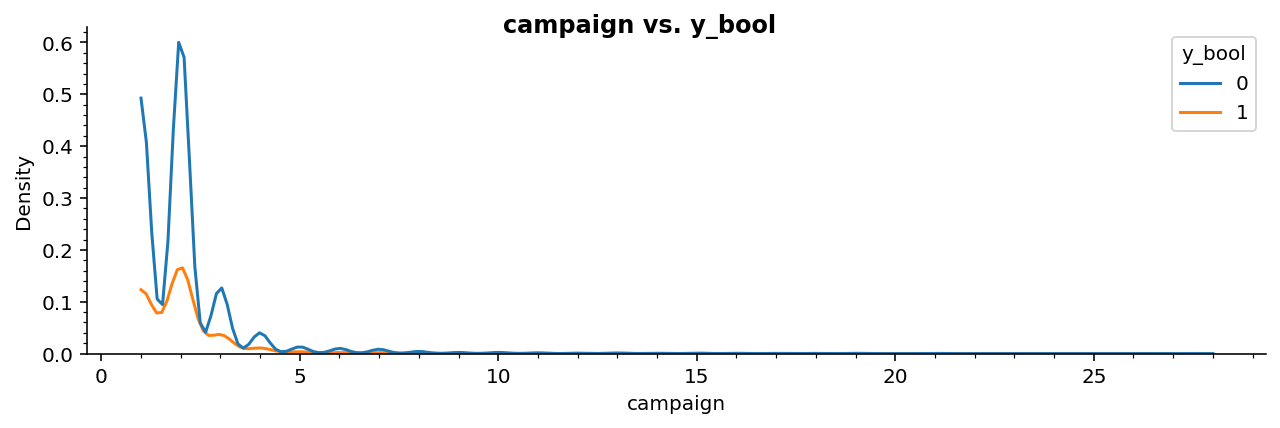

In [236]:
explore_cont('campaign')

In [237]:
train.campaign.nunique(), test.campaign.nunique()

(26, 22)

In [238]:
bins = [0, 1, 5, 10, 28]
train['campaign_bins']= pd.cut(x=train['campaign'], bins=bins, labels=False)
test['campaign_bins'] = pd.cut(x=test['campaign'], bins=bins, labels=False)

In [239]:
explore_cat('campaign_bins')


Number of unique values: Train - 4, Test - 4
Unique values: 
Train - [1 0 2 3]
Test - [0 1 2 3]

Normalized value counts:


,1,0,2,3
campaign_bins_Train,0.6074,0.3664,0.0194,0.0069
campaign_bins_Test,0.6089,0.3689,0.0163,0.0059



Target value counts grouped by feature:


campaign_bins  y_bool
0              0         0.7417
               1         0.2583
1              0         0.7242
               1         0.2758
2              0         0.7764
               1         0.2236
3              0         0.6181
               1         0.3819
Name: y_bool, dtype: float64

### pdays


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,3.2320,23.1615,-1.0,-1.0,-1.0,-1.0,437.0
Test,9000.0,2.8774,22.6264,-1.0,-1.0,-1.0,-1.0,368.0


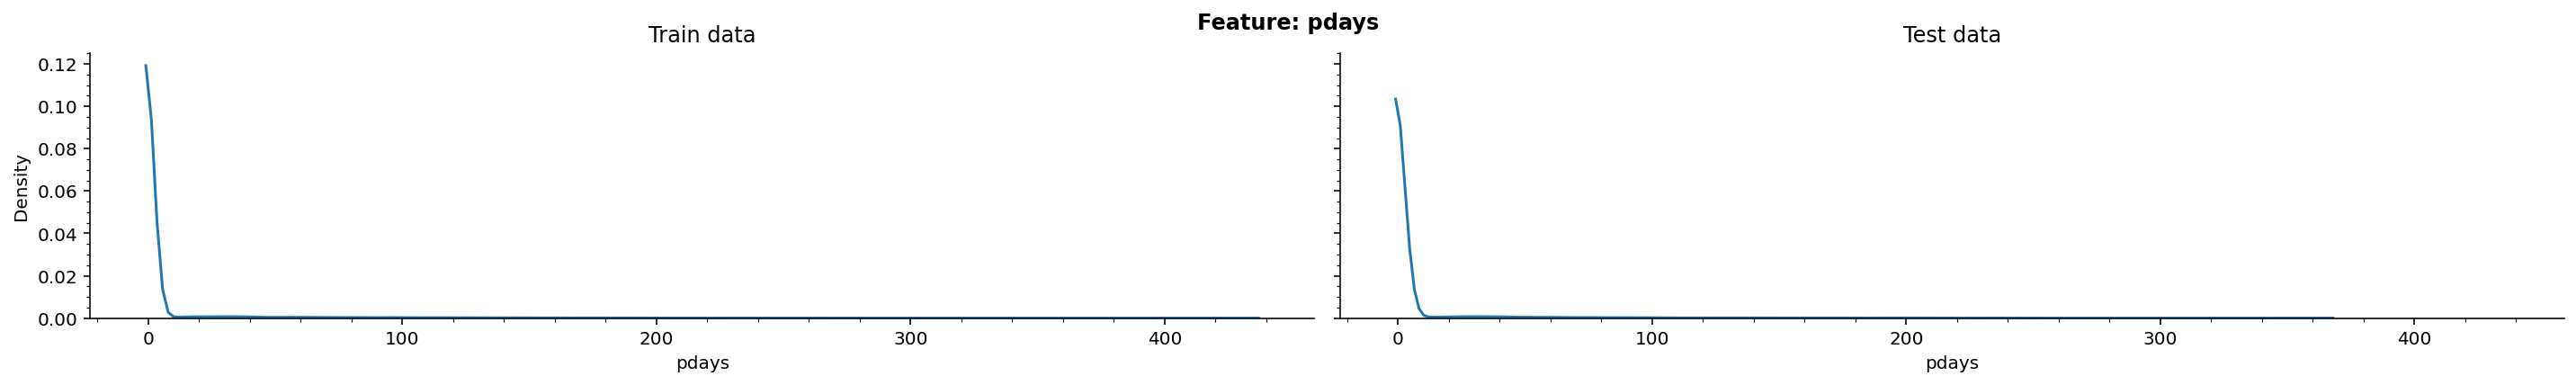


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,3.3602,23.2820,-1.0,-1.0,-1.0,-1.0,367.0
1,5651.0,2.8836,22.8294,-1.0,-1.0,-1.0,-1.0,437.0


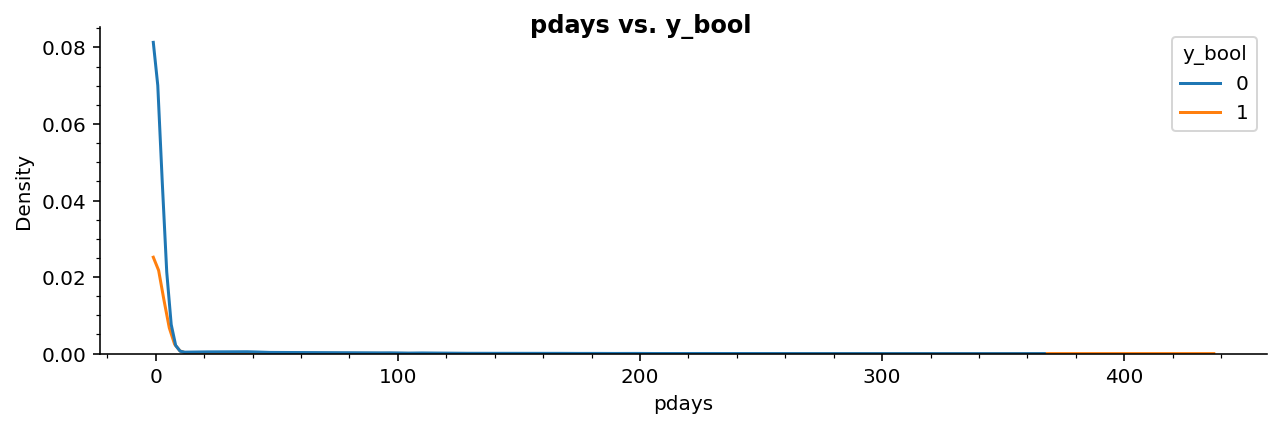

In [240]:
explore_cont('pdays')

In [241]:
train.loc[train.pdays > -1]['pdays'].describe()

count    1128.0000
mean       77.7863
std        64.1599
min         5.0000
25%        31.0000
50%        58.0000
75%       107.0000
max       437.0000
Name: pdays, dtype: float64

In [242]:
test.loc[test.pdays > -1]['pdays'].describe()

count    451.0000
mean      76.3769
std       67.3656
min        6.0000
25%       31.0000
50%       54.0000
75%       98.0000
max      368.0000
Name: pdays, dtype: float64

In [243]:
bins = [-2, -1, 30, 60, 120, 500]
train['pdays_bins']= pd.cut(x=train['pdays'], bins=bins, labels=False)
test['pdays_bins'] = pd.cut(x=test['pdays'], bins=bins, labels=False)

In [244]:
explore_cat('pdays_bins')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [0 4 1 2 3]
Test - [0 4 2 1 3]

Normalized value counts:


,0,3,2,1,4
pdays_bins_Train,0.9463,0.0153,0.0148,0.0130,0.0106
pdays_bins_Test,0.9499,0.0124,0.0159,0.0122,0.0096



Target value counts grouped by feature:


pdays_bins  y_bool
0           0         0.7295
            1         0.2705
1           0         0.7436
            1         0.2564
2           0         0.7621
            1         0.2379
3           0         0.7570
            1         0.2430
4           0         0.7578
            1         0.2422
Name: y_bool, dtype: float64

In [245]:
train['pdays_bool'] = (train.pdays > -1).astype('int')
test['pdays_bool'] = (test.pdays > -1).astype('int')

In [246]:
explore_cat('pdays_bool')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [0 1]
Test - [0 1]

Normalized value counts:


,0,1
pdays_bool_Train,0.9463,0.0537
pdays_bool_Test,0.9499,0.0501



Target value counts grouped by feature:


pdays_bool  y_bool
0           0         0.7295
            1         0.2705
1           0         0.7553
            1         0.2447
Name: y_bool, dtype: float64

### previous


Feature distribution:


,count,mean,std,min,25%,50%,75%,max
Train,21000.0,0.1025,0.6644,0.0,0.0,0.0,0.0,14.0
Test,9000.0,0.0962,0.6809,0.0,0.0,0.0,0.0,25.0


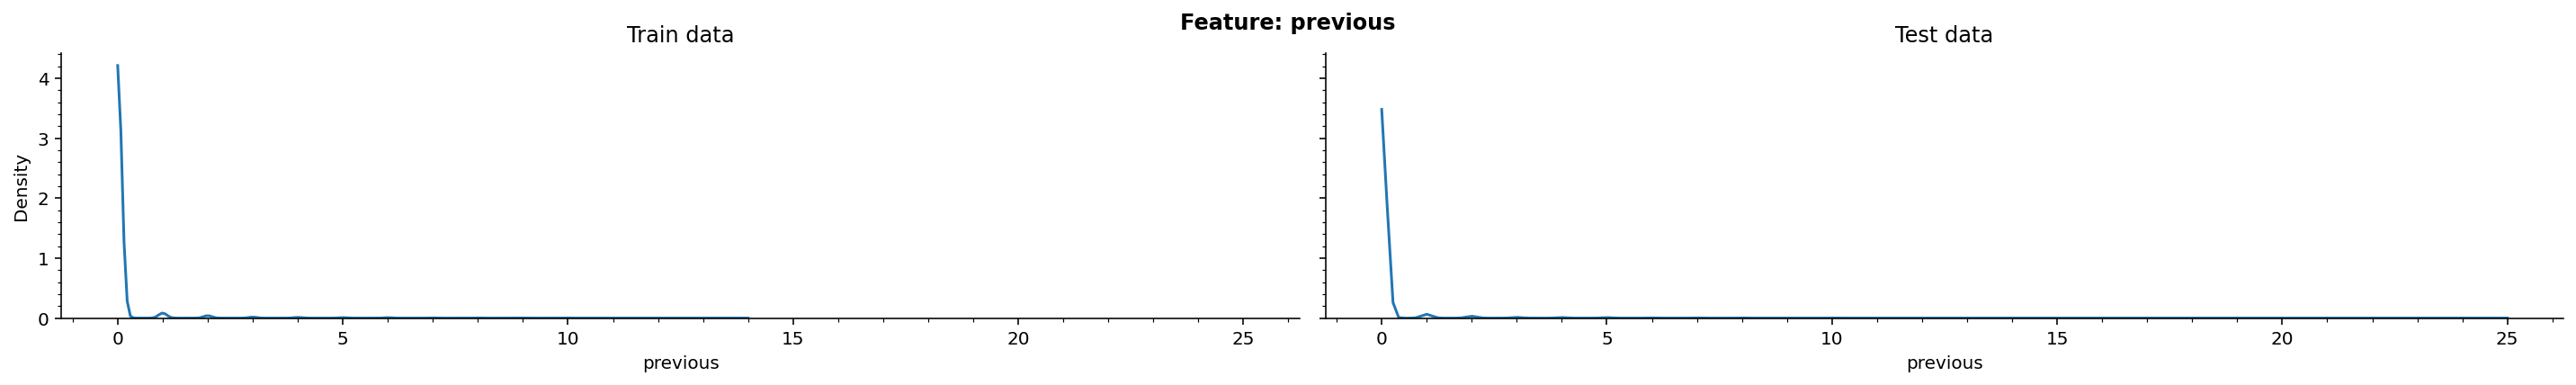


Feature distribution vs target variable:


,count,mean,std,min,25%,50%,75%,max
y_bool,,,,,,,,
0,15349.0,0.1050,0.6833,0.0,0.0,0.0,0.0,14.0
1,5651.0,0.0959,0.6099,0.0,0.0,0.0,0.0,12.0


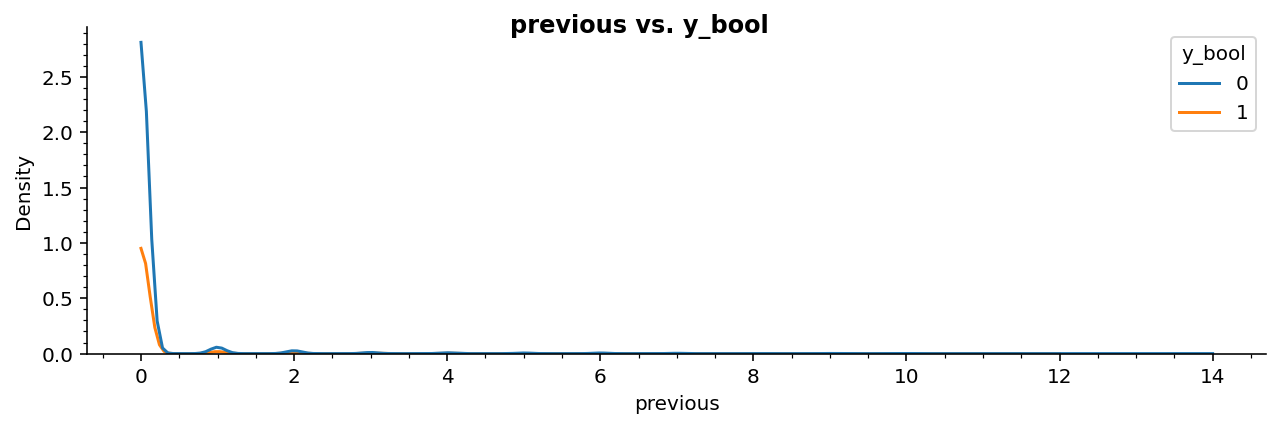

In [247]:
explore_cont('previous')

In [248]:
train.loc[train.previous > 0]['previous'].describe()

count    867.0000
mean       2.4833
std        2.1871
min        1.0000
25%        1.0000
50%        2.0000
75%        3.0000
max       14.0000
Name: previous, dtype: float64

In [249]:
train.previous.nunique(), test.previous.nunique()

(15, 15)

In [250]:
explore_cat('previous')


Number of unique values: Train - 15, Test - 15
Unique values: 
Train - [ 0  2  5  1  3  4  6  8  9  7 11 12 10 14 13]
Test - [ 0  4  1  2  3  5  6  8  7 10  9 13 25 12 11]

Normalized value counts:


,0,1,2,3,4,5,6,7,8,9,10,11,12,14,13
previous_Train,0.9587,0.0194,0.0092,0.0038,0.0028,0.0019,0.0018,0.0008,0.0005,0.0004,0.0004,0.0002,0.0001,4.7619e-05,4.7619e-05
previous_Test,0.9619,0.0178,0.0086,0.0034,0.0027,0.0023,0.0008,0.0008,0.0007,0.0002,0.0004,0.0001,0.0001,NaN,1.1111e-04



Target value counts grouped by feature:


previous  y_bool
0         0         0.7307
          1         0.2693
1         0         0.7469
          1         0.2531
2         0         0.7150
          1         0.2850
3         0         0.6750
          1         0.3250
4         0         0.6724
          1         0.3276
5         0         0.7436
          1         0.2564
6         0         0.7838
          1         0.2162
7         0         1.0000
8         0         0.8000
          1         0.2000
9         0         0.7778
          1         0.2222
10        0         0.7500
          1         0.2500
11        0         0.8000
          1         0.2000
12        0         0.6667
          1         0.3333
13        0         1.0000
14        0         1.0000
Name: y_bool, dtype: float64

In [251]:
bins = [-1, 0, 1, 2, 3, 25]
train['previous_bins']= pd.cut(x=train['previous'], bins=bins, labels=False)
test['previous_bins'] = pd.cut(x=test['previous'], bins=bins, labels=False)

In [252]:
explore_cat('previous_bins')


Number of unique values: Train - 5, Test - 5
Unique values: 
Train - [0 2 4 1 3]
Test - [0 4 1 2 3]

Normalized value counts:


,0,1,2,4,3
previous_bins_Train,0.9587,0.0194,0.0092,0.0089,0.0038
previous_bins_Test,0.9619,0.0178,0.0086,0.0083,0.0034



Target value counts grouped by feature:


previous_bins  y_bool
0              0         0.7307
               1         0.2693
1              0         0.7469
               1         0.2531
2              0         0.7150
               1         0.2850
3              0         0.6750
               1         0.3250
4              0         0.7594
               1         0.2406
Name: y_bool, dtype: float64

In [253]:
train['previous_bool'] = (train.previous > 0).astype('int')
test['previous_bool'] = (test.previous > 0).astype('int')

In [254]:
explore_cat('previous_bool')


Number of unique values: Train - 2, Test - 2
Unique values: 
Train - [0 1]
Test - [0 1]

Normalized value counts:


,0,1
previous_bool_Train,0.9587,0.0413
previous_bool_Test,0.9619,0.0381



Target value counts grouped by feature:


previous_bool  y_bool
0              0         0.7307
               1         0.2693
1              0         0.7359
               1         0.2641
Name: y_bool, dtype: float64

### poutcome

In [255]:
explore_cat('poutcome')


Number of unique values: Train - 4, Test - 4
Unique values: 
Train - ['unknown' 'success' 'failure' 'other']
Test - ['unknown' 'other' 'failure' 'success']

Normalized value counts:


,unknown,failure,other,success
poutcome_Train,0.7679,0.1818,0.0319,0.0184
poutcome_Test,0.7536,0.1918,0.0354,0.0192



Target value counts grouped by feature:


poutcome  y_bool
failure   0         0.7420
          1         0.2580
other     0         0.7328
          1         0.2672
success   0         0.6899
          1         0.3101
unknown   0         0.7292
          1         0.2708
Name: y_bool, dtype: float64

In [256]:
train.groupby('poutcome')['previous'].describe()

,count,mean,std,min,25%,50%,75%,max
poutcome,,,,,,,,
failure,3818.0,0.1053,0.6840,0.0,0.0,0.0,0.0,13.0
other,670.0,0.1239,0.7949,0.0,0.0,0.0,0.0,14.0
success,387.0,0.1189,0.7062,0.0,0.0,0.0,0.0,9.0
unknown,16125.0,0.1006,0.6526,0.0,0.0,0.0,0.0,12.0


In [257]:
train.groupby('poutcome')['pdays'].describe()

,count,mean,std,min,25%,50%,75%,max
poutcome,,,,,,,,
failure,3818.0,3.2800,23.9310,-1.0,-1.0,-1.0,-1.0,367.0
other,670.0,3.0269,20.8438,-1.0,-1.0,-1.0,-1.0,282.0
success,387.0,2.1628,24.5232,-1.0,-1.0,-1.0,-1.0,362.0
unknown,16125.0,3.2548,23.0352,-1.0,-1.0,-1.0,-1.0,437.0


In [258]:
category_mappings['poutcome'] = {'unknown': -1, 'other': -1, 'failure': 0, 'success': 1}

### Encoding categorical columns

In [259]:
features = list(test.columns)
num_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_features = [f for f in features if f not in num_features]

In [260]:
def encode_cat(df):
    for col in cat_features:
        mapping = category_mappings.get(col)
        if mapping:
            df[col] = df[col].replace(mapping).astype('int8')
        else:
            df[col] = df[col].astype('int8')
    
    return df

In [261]:
train = encode_cat(train)
test = encode_cat(test)

# Feature selection

### Pearson correlation

In [263]:
def plot_corr_matrix(corr_df, size=15):
    plt.figure(figsize=(size, size))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, fmt='.2f',
                linewidths=0.1)
    plt.show()

In [264]:
corr_df = train[features + [TARGET]].corr()

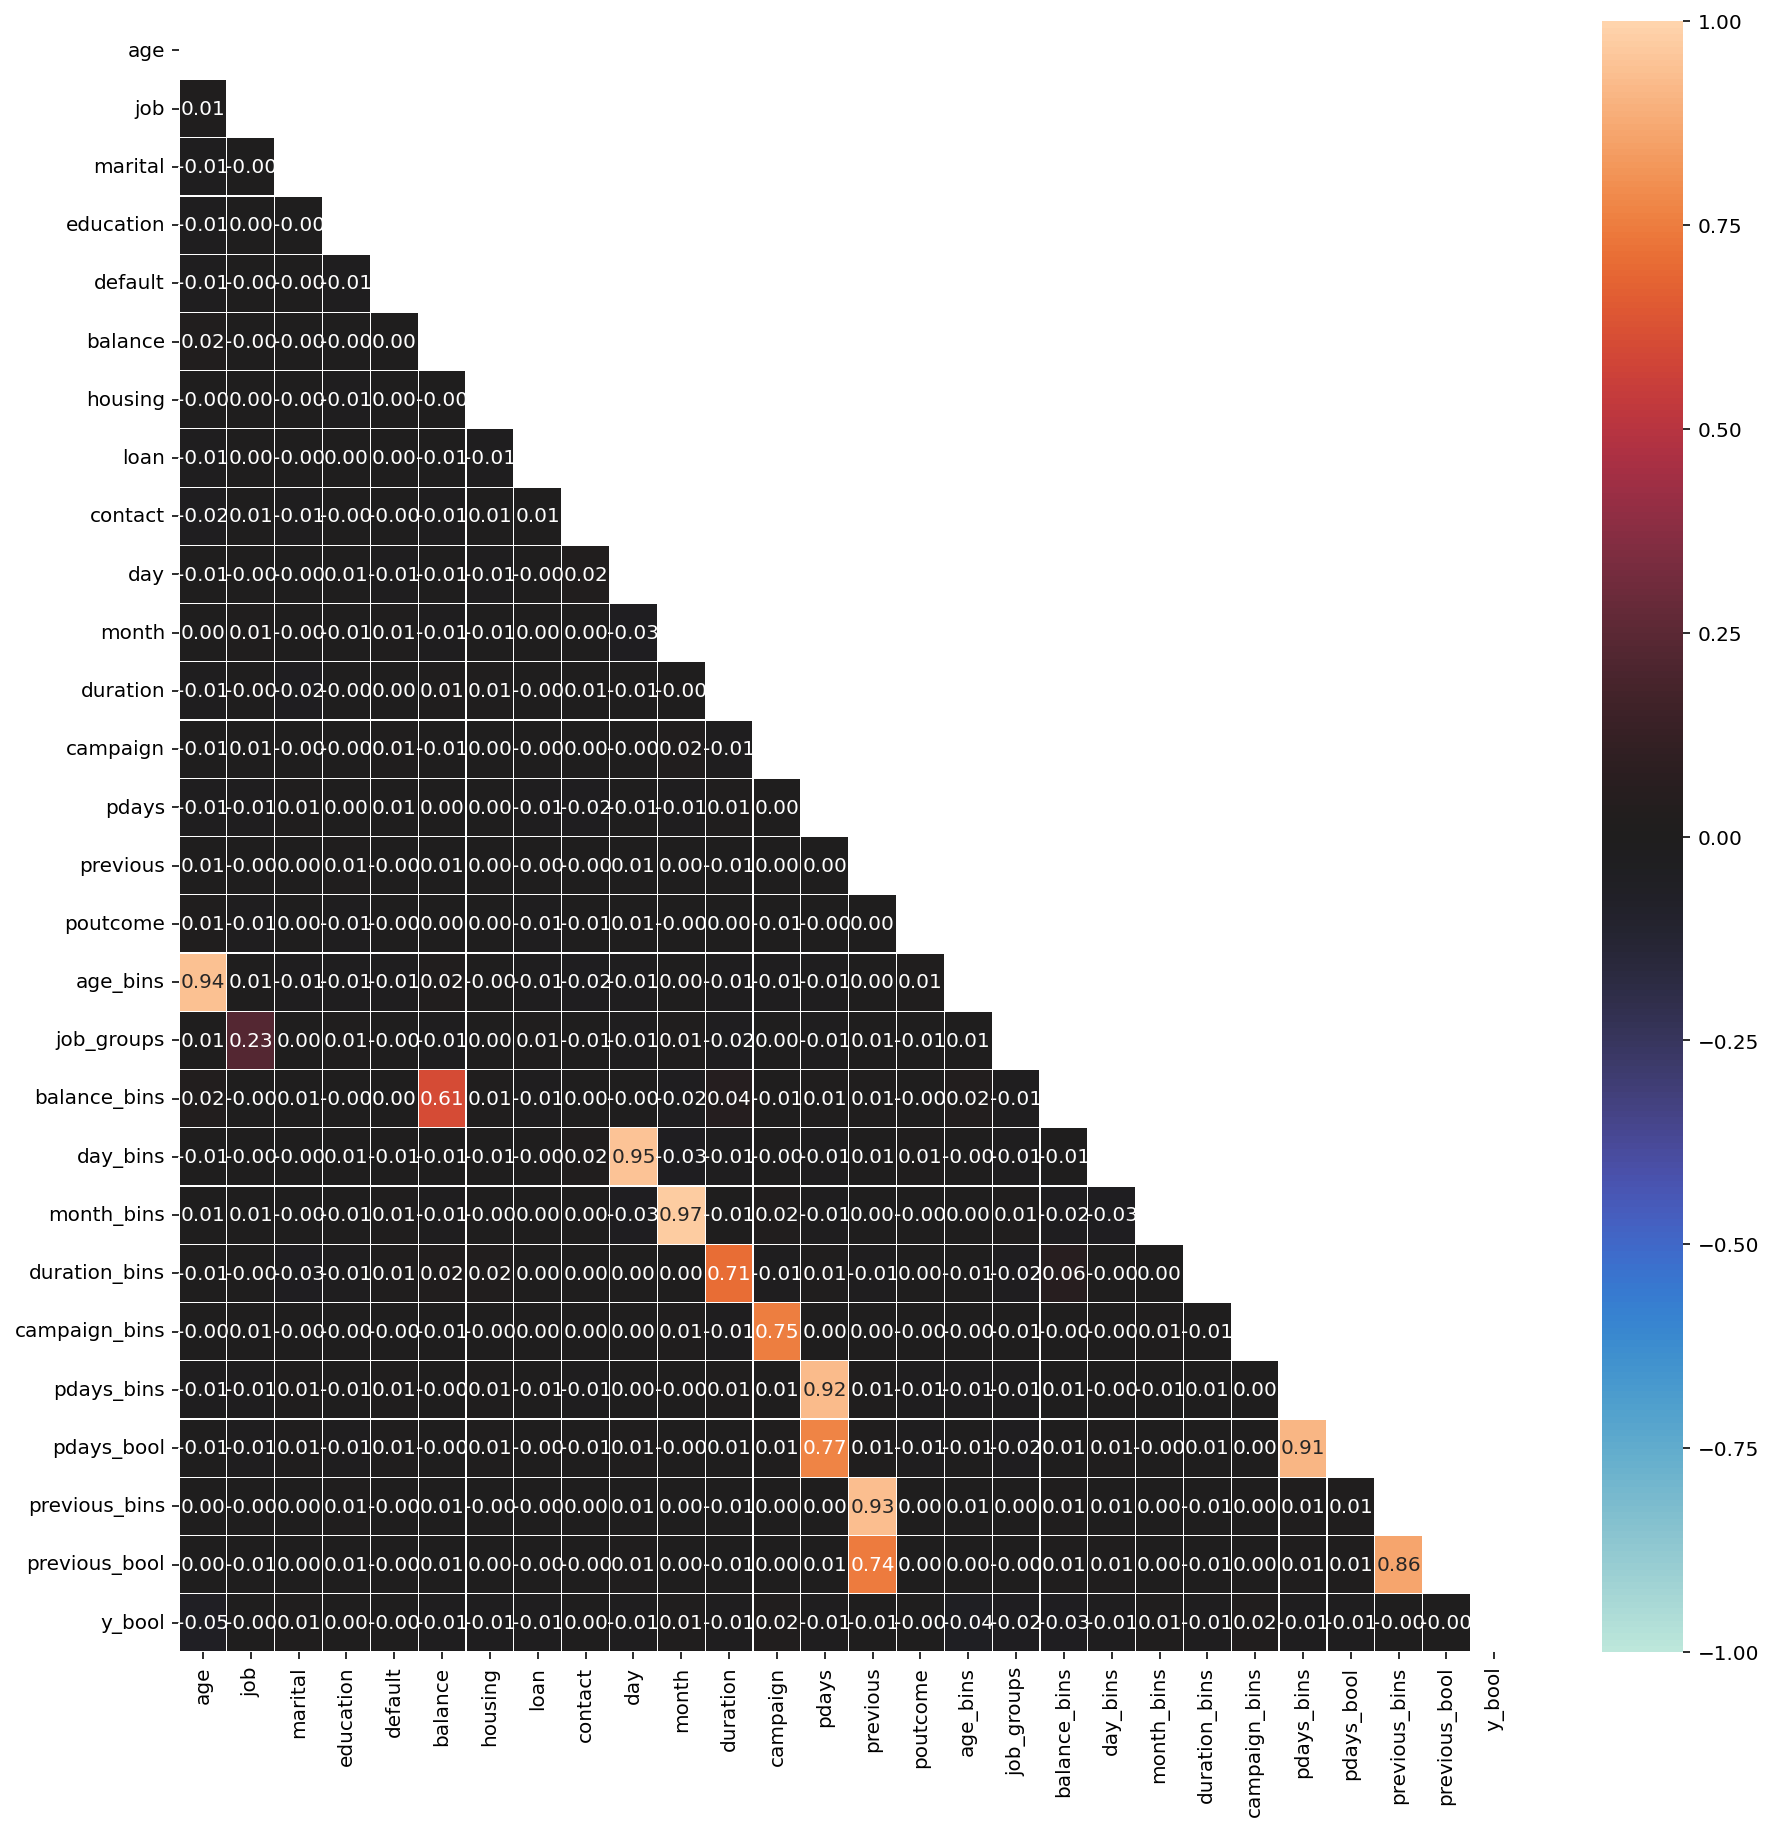

In [265]:
plot_corr_matrix(corr_df)

### Variance Inflation Factor (VIF)

In [266]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [267]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while True:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)
        if max_vif <= threshold:
            break
        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)
    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Feature": X.columns, "VIF": vif}))
    return list(X.columns)

In [268]:
_ = remove_vif_features(train[num_features], 2.5)

Iteration 1: age                  (4.3683)
    Feature     VIF
0   balance  1.2274
1       day  2.0232
2  duration  1.5778
3  campaign  1.9064
4     pdays  1.0168
5  previous  1.0203


### ANOVA F-test

In [269]:
anova_test = f_classif(train[num_features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=num_features
)

,f-statistic,p-value,accepted?
age,52.1131,5.4178e-13,True
balance,2.4089,1.2066e-01,False
day,1.5791,2.0891e-01,False
duration,3.0169,8.2416e-02,False
campaign,6.3599,1.1680e-02,True
pdays,1.7494,1.8597e-01,False
previous,0.7657,3.8155e-01,False


### Mutual Information score

In [271]:
cat_mask = [(f in cat_features) for f in features] #boolean mask for discrete features

mi_scores = mutual_info_classif(train[features], train[TARGET], 
                                discrete_features=cat_mask, 
                                random_state=SEED)
pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_bins,job_groups,balance_bins,day_bins,month_bins,duration_bins,campaign_bins,pdays_bins,pdays_bool,previous_bins,previous_bool
mi_score,0.001,0.0005,5.5199e-05,7.3398e-06,3.6996e-07,7.6918e-05,8.5694e-05,6.5578e-05,8.3205e-05,0.0002,0.0005,0.0,0.0,0.0,0.0032,0.0001,0.0011,0.0005,0.0008,0.0002,0.0005,8.7588e-05,0.0005,9.4574e-05,8.7653e-05,6.6603e-05,2.7100e-06


### Feature sets

In [274]:
original_features

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

In [275]:
cat_only_features = ['age_bins', 'job_groups', 'marital', 'education', 'default',
                     'balance_bins', 'housing', 'loan', 'contact', 'day_bins', 
                     'month_bins', 'duration_bins', 'campaign_bins', 'pdays_bins',
                     'pdays_bool', 'previous_bins', 'previous_bool', 'poutcome']

# Processed dataset

In [276]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

# Baseline

In [297]:
%%time
X, y = train[original_features], train[TARGET]
X_test = test[original_features]
scores = []
test_preds_og = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = RandomForestClassifier(
        n_estimators=250, 
        max_depth=6,
        n_jobs=-1, 
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]
    test_preds_og[f'fold{fold}'] = model.predict_proba(X_test)[:, 1]

    score = log_loss(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: Logloss = {score:.5f}')
    _ = gc.collect()

print(f'\nAvg Logloss = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

test_preds_og = pd.DataFrame.from_dict(test_preds_og)
test_preds_og['mean'] = test_preds_og.mean(axis=1)

Fold #0: Logloss = 0.58060
Fold #1: Logloss = 0.58088
Fold #2: Logloss = 0.57973
Fold #3: Logloss = 0.58200
Fold #4: Logloss = 0.58107

Avg Logloss = 0.58086 +/- 0.00073

CPU times: user 22.9 s, sys: 450 ms, total: 23.3 s
Wall time: 16 s


In [298]:
%%time
X, y = train[cat_only_features], train[TARGET]
X_test = test[cat_only_features]
scores = []
test_preds_cat = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = RandomForestClassifier(
        n_estimators=250,  
        max_depth=6,
        # class_weight='balanced',
        n_jobs=-1, 
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]
    test_preds_cat[f'fold{fold}'] = model.predict_proba(X_test)[:, 1]

    score = log_loss(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: Logloss = {score:.5f}')
    _ = gc.collect()

print(f'\nAvg Logloss = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

test_preds_cat = pd.DataFrame.from_dict(test_preds_cat)
test_preds_cat['mean'] = test_preds_cat.mean(axis=1)

Fold #0: Logloss = 0.58073
Fold #1: Logloss = 0.58092
Fold #2: Logloss = 0.57916
Fold #3: Logloss = 0.58132
Fold #4: Logloss = 0.58124

Avg Logloss = 0.58067 +/- 0.00079

CPU times: user 16.2 s, sys: 533 ms, total: 16.7 s
Wall time: 10.9 s


In [299]:
%%time
X, y = train[features], train[TARGET]
X_test = test[features]
scores = []
test_preds_all = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

    model = RandomForestClassifier(
        n_estimators=250,  
        max_depth=6,
        # class_weight='balanced',
        n_jobs=-1, 
        random_state=SEED
    )

    model.fit(X_train, y_train)
    val_probs = model.predict_proba(X_val)[:, 1]
    test_preds_all[f'fold{fold}'] = model.predict_proba(X_test)[:, 1]

    score = log_loss(y_val, val_probs)
    scores.append(score)
    print(f'Fold #{fold}: Logloss = {score:.5f}')
    _ = gc.collect()

print(f'\nAvg Logloss = {np.mean(scores):.5f} +/- {np.std(scores):.5f}\n')

test_preds_all = pd.DataFrame.from_dict(test_preds_all)
test_preds_all['mean'] = test_preds_all.mean(axis=1)

Fold #0: Logloss = 0.58044
Fold #1: Logloss = 0.58069
Fold #2: Logloss = 0.57903
Fold #3: Logloss = 0.58159
Fold #4: Logloss = 0.58064

Avg Logloss = 0.58048 +/- 0.00082

CPU times: user 22.4 s, sys: 495 ms, total: 22.9 s
Wall time: 13.6 s


# Submission files

In [300]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [301]:
NOTEBOOK = '00'
SUBMISSION_PATH = f'/content/drive/MyDrive/data_science_competitions/machinehack/subscriber_prediction_hackathon/submissions/nb_{NOTEBOOK}'
if not os.path.isdir(SUBMISSION_PATH):
    os.makedirs(SUBMISSION_PATH)

In [302]:
def create_submission_files(test_preds, feature_set):
    for col in test_preds.columns:
        sub = sample_sub.copy()
        sub[TARGET] = test_preds[col]
        sub.to_csv(f'{SUBMISSION_PATH}/{feature_set}_{col}.csv', index=False)

In [303]:
create_submission_files(test_preds_og, 'og')

In [304]:
create_submission_files(test_preds_cat, 'cat')

In [305]:
create_submission_files(test_preds_cat, 'all')